#Loading the Pretrained Model and Dataset

In [ ]:
!git clone https://github.com/analytics-club-iitm/DL-Marathon
!cd ./img-cls/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

In [ ]:
bs = 1   # batch size

# ConvNet definition
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.3)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(0.4)
        )

        self.fc = nn.Linear(128, 10)  # number of classes =10

    def forward(self, x):
        x = self.conv6(self.conv5(self.conv4(self.conv3(self.conv2(self.conv1(x))))))
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)

        x = self.fc(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
#loading pretrained weights
path = './best.ckpt'

#loading/dowloading the test dataset for evaluation
cifar_test_dataset=torchvision.datasets.CIFAR10(
    root = './data',
    transform = transforms.Compose([
            transforms.Resize([32, 32]),
            transforms.ToTensor(), 
            transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])
    ]),
    download=True,
    train=False
)

testdataloader = torch.utils.data.DataLoader(cifar_test_dataset, batch_size=bs, shuffle = True, num_workers=4)

model = NeuralNet().cuda()
model.load_state_dict(torch.load(path))
model.eval()

Files already downloaded and verified


NeuralNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=

In [ ]:
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

{0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}


# The concept of Receptive Field

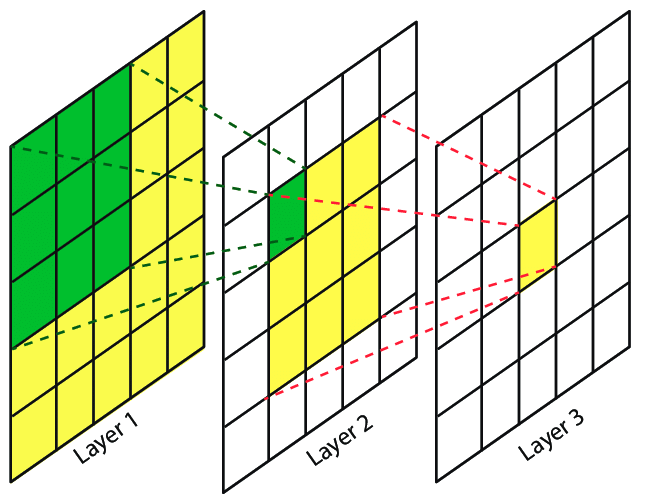

Consider that we have a two-layered Convolution Neural Network and we are using 3x3 filters through the network. The green pixel we see in Layer 2 is the result of the convolution operation being applied on the green 3x3 patch in Layer 1. Now the central yellow pixel we see in Layer 3 is a result of 3x3 convolution operation in layer 2.

The **receptive field** of a neuron is defined as the region in the input image that can influence the neuron in a convolution layer i.e how many pixels in the original image are influencing the neuron present in a convolution layer. In this example we see that the yellow pixel in Layer 3 has a receptive field of 5X5. Thus, as the network goes deeper, the more the receptive field will be and features are captured better.

#Occlusion Sensitivity Analysis

In order to fully understand whether model has learned to identify the position of the object or its using the surrounding context, we perform something called an occlusion sensitivity experiment. We systematically occlude or block different portions of the input image with a grey square and we monitor the output of the of the classifier.

In [ ]:
"""Custom function to display the image"""

def imshow(img, title):
  #plot the numpy image
  plt.figure(figsize = (bs * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(img, (1, 2, 0)))
  plt.title(title)
  plt.show()

In [ ]:
'''custom function to fetch images from dataloader'''

def show_batch_images(dataloader):
  images, target = next(iter(dataloader))
  
  #run the model on the images
  outputs = model(images.cuda())
  
  #get the maximum class 
  _, pred = torch.max(outputs.data, 1)
  
  #make grid
  img = torchvision.utils.make_grid(images, nrow=1, normalize=True, range=(-1, 1))
  
  #call the function
  imshow(img, title=[classes[x.item()] for x in pred])
  
  return images, pred, target

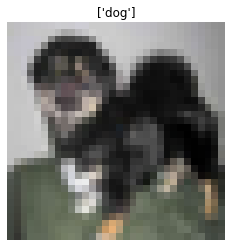

In [ ]:
images, pred, target = show_batch_images(testdataloader)

In [ ]:
#running inference on the images without occlusion on the pretrained model

outputs = model(images.cuda())
print(outputs.shape)

#passing the outputs through softmax to interpret them as probability
outputs = torch.exp(outputs)
outputs[0, pred]

torch.Size([1, 10])


tensor([0.3812], device='cuda:0', grad_fn=<IndexBackward>)

In [ ]:
#custom function to conduct occlusion experiments

def occlude(model, image, label, osize = 3, ostride = 1, opixel = 0.5):

    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output width and height
    o_height = int(np.ceil((height-osize)/ostride))
    o_width = int(np.ceil((width-osize)/ostride))
  
    #create a heatmap of sizes we defined
    hmap = torch.zeros((o_height, o_width))
    
    #iterate all the pixels column-wise
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*ostride
            w_start = w*ostride
            h_end = min(height, h_start + osize)
            w_end = min(width, w_start + osize)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing the pixel info in the image with opixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = opixel
            
            #run the image through the model and obtain the probability 
            output = model(input_image)
            prob = output.tolist()[0][label]
            
            #heatmap location = probability value
            hmap[h, w] = prob 

    return hmap


In [ ]:
    hmap = occlude(model, images.cuda(), pred[0].item()) #chosen occluding patch size is 3x3
    print(hmap.shape)

torch.Size([29, 29])


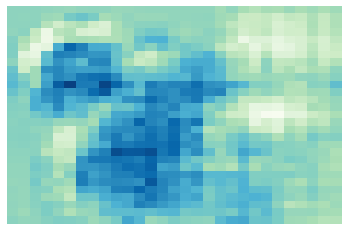

In [ ]:

#displaying the image using seaborn heatmap and also setting the maximum value of gradient to probability
heatplot = sns.heatmap(hmap, xticklabels=False, yticklabels=False,cbar=False, cmap = 'GnBu')
figure = heatplot.get_figure()   
figure.savefig('svm_conf.png', dpi=400)

We see that the model indeed captures part of the image that are significant to its identity (eg: horns of a deer, green colour of a frog etc.) but for some images the nature of the surroundings maybe be taken into consideration as well (eg: blue sky behind an airplane)
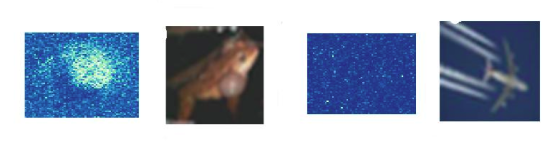

# Filter Visualisation

Now we will see how the filter captures features of the images in the initial layers
 

In [ ]:
def plot_filters_multi_channel(t):
    
    #Number of kernels
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_weights(model, collated = False):
  
  #extracting the model features at the particular layer number
    weight_tensor = model.conv1[0].weight.data
    weight_tensor = weight_tensor.cpu()
    if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
    else:
        print("Can only plot weights with three channels with single channel = False")

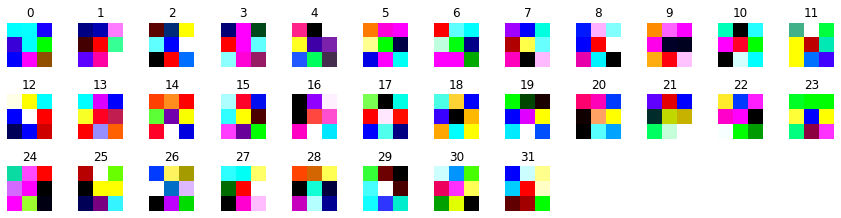

In [ ]:
plot_weights(model)

From the filters above you can see that we cant conclude as much as we could because of the smaller filter size and small image size present in the cifar10 dataset. Lets look at the filters of a popular convolutional network architecture called ALexNet, which is trained on the higher quality of images in ImageNet Dataset.

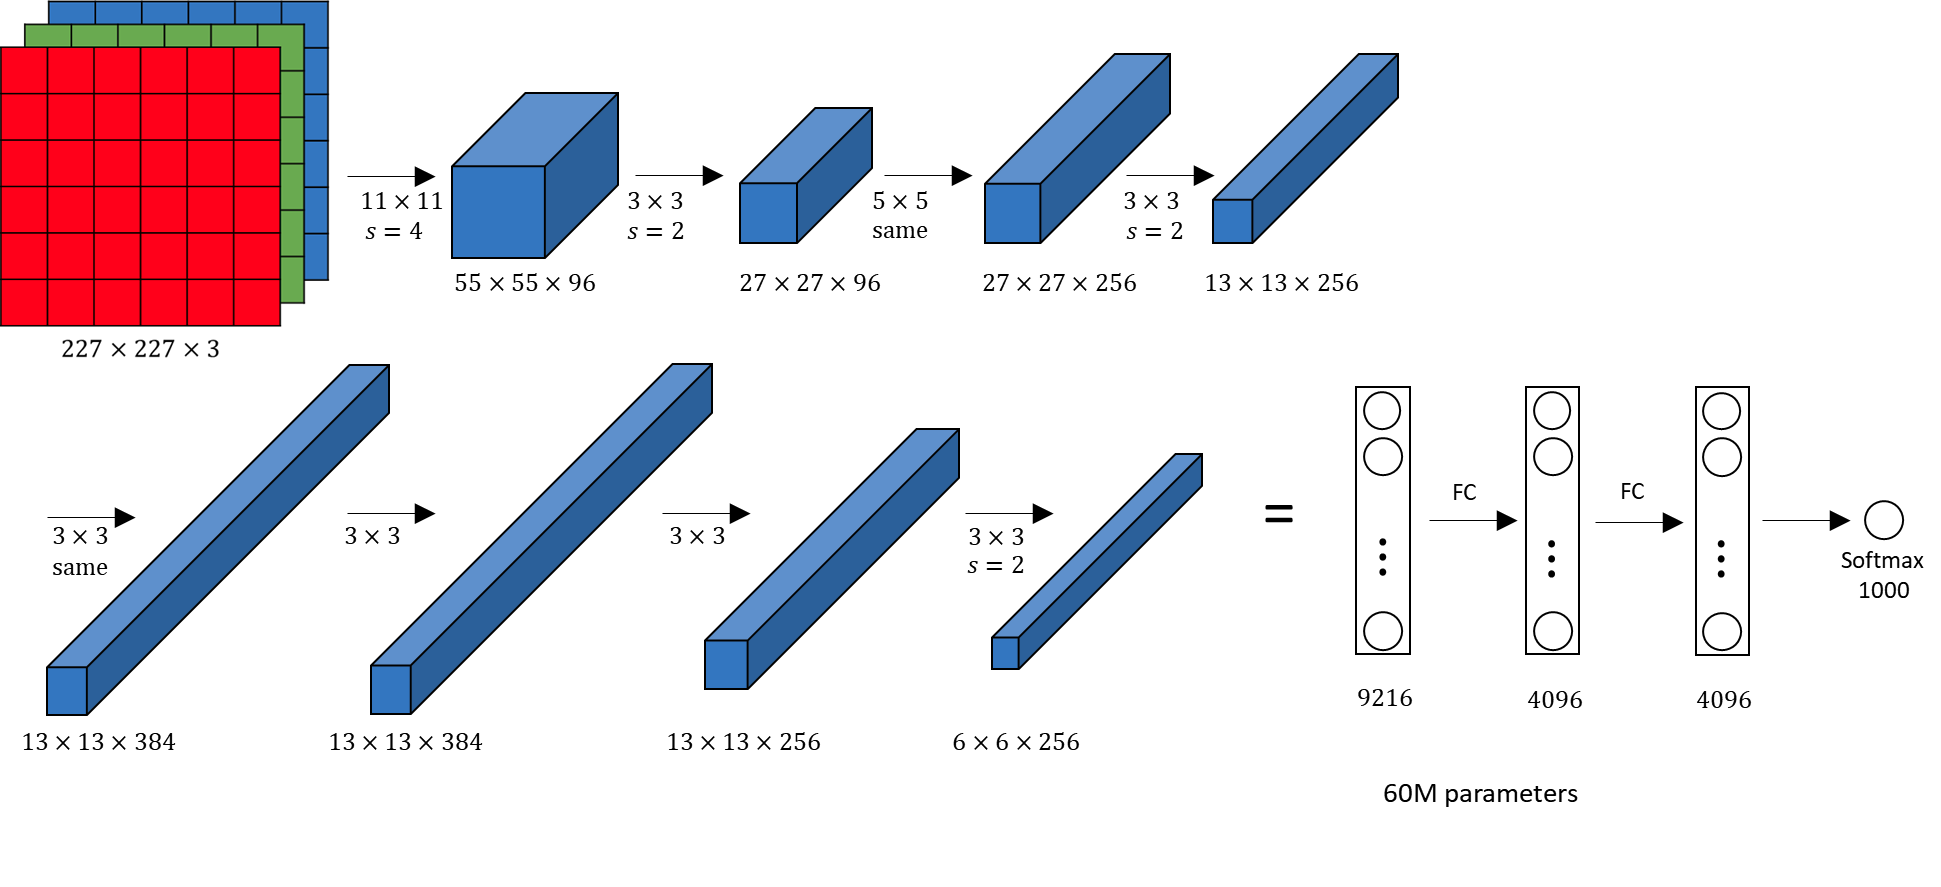


In [ ]:
import torchvision.models as models
alexnet = models.alexnet(pretrained=True)

In [ ]:
def plot_weights_alexnet(model):
  
  #extracting the model features at the particular layer number
  layer = model.features[0]
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = model.features[0].weight.data        
    if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
    else:
        print("Can only plot weights with three channels with single channel = False")

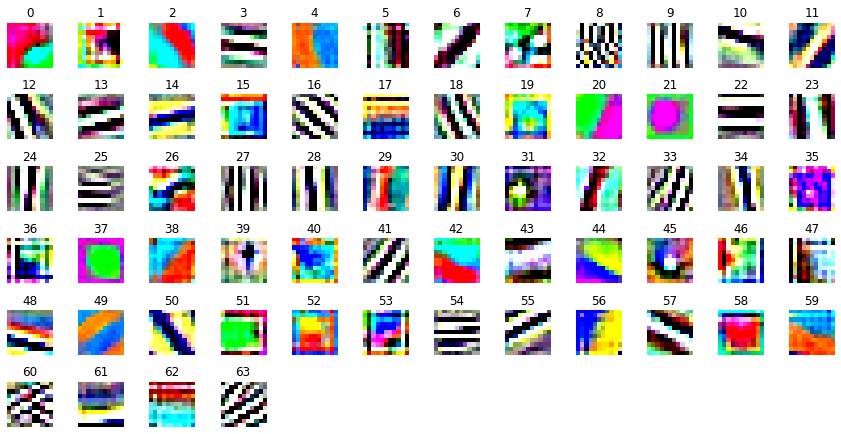

In [ ]:
plot_weights_alexnet(alexnet)

Here we see that the filters are depicting some significant feature which are more rudimentary in nature such as edges, circles, corners, stripes etc.

Lets see how receptive fields and feature mapping work hand in hand. 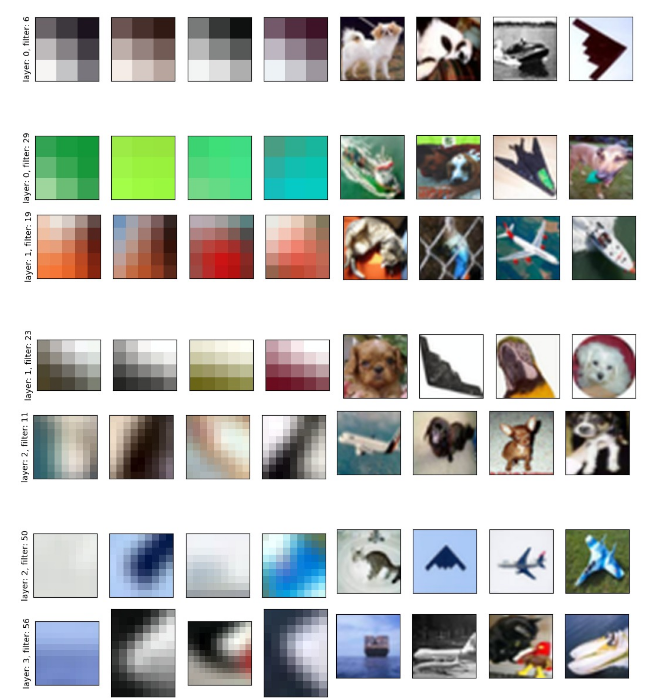

Here we see that in the initial few layers, edge and corner information are captured with their respective small receptive field sizes. As we go deeper, the recptive field of the filters increases and more visual information can be captured easily and goes on to identify the object in the image.